# LowLou PINN

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

import numpy as np 
import matplotlib.pyplot as plt
import torch
import time

from zpinn.create_pot import get_potential_boundary
from zpinn.pinn_nf2_cleanup import create_coordinates, NF2Trainer

<matplotlib.image.AxesImage>

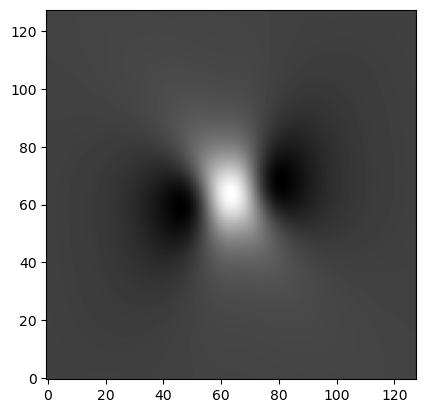

In [ ]:
input_path = '01_input/lowlou_128128128/'
bottom_npy_path = os.path.join(input_path, 'b_bottom.npy')

with open(bottom_npy_path, 'rb') as f:
        b_bottom = np.load(f)

plt.imshow(b_bottom[:, :, 2].transpose(), origin='lower', cmap='gray')

In [ ]:
output_path = '02_output/lowlou_128128128/PINN'

Nx, Ny, _ = b_bottom.shape
Nz = 128

spatial_norm = 32
b_norm = 100

In [ ]:
boundary_path = os.path.join(output_path, 'boundary')
os.makedirs(boundary_path, exist_ok=True)

boundary_npy_path = os.path.join(boundary_path, 'boundary_data.npy')

In [ ]:
total_iterations = 2000
log_interval = 100

num_neurons = 256
num_layers = 8

w_ff = 1
w_div = 1
w_bc_init = 1000
decay_iterations = 25000

lr_init = 5e-4
lr_final = 5e-5
lr_decay_iterations = 50000

batch_size = 10000
num_worker = 2

## Create boundary data

In [ ]:
bottom_values = b_bottom.reshape(-1, 3)
bottom_bounds = (0, Nx-1, 0, Ny-1, 0, 0)
bottom_coords = create_coordinates(bottom_bounds).reshape(-1, 3)

coords, fields = get_potential_boundary(b_bottom[:, :, 2], Nz)

for i in range(len(coords)):
    coords[i] = np.reshape(coords[i], (-1, 3))
    fields[i] = np.reshape(fields[i], (-1, 3))

top_lateral_values = np.concatenate(fields) 
top_lateral_coords = np.concatenate(coords)

boundary_values = np.concatenate([top_lateral_values, bottom_values])
boundary_coords = np.concatenate([top_lateral_coords, bottom_coords])

normalized_boundary_values = boundary_values / b_norm
normalized_boundary_coords = boundary_coords / spatial_norm

boundary_data = np.stack([normalized_boundary_coords, normalized_boundary_values], 1)

with open(boundary_npy_path, 'wb') as f:
        np.save(f, boundary_data)

Potential Field: 100%|██████████| 120/120 [00:03<00:00, 34.48it/s]


## PINN

In [ ]:
torch.set_num_threads(num_worker)

In [ ]:
with open(boundary_npy_path, 'rb') as f:
        boundary_data = np.load(f)

In [ ]:
trainer = NF2Trainer(output_path, b_bottom, height=Nz, b_norm=b_norm, spatial_norm=spatial_norm, meta_info=None, boundary_data=boundary_data)

In [ ]:
trainer.setup(total_iterations=total_iterations, batch_size=batch_size, log_interval=log_interval, num_workers=num_worker,
              num_neurons=num_neurons, num_layers=num_layers, w_ff=w_ff, w_div=w_div, w_bc_init=w_bc_init, decay_iterations=decay_iterations,
              lr_init=lr_init, lr_final=lr_final, lr_decay_iterations=lr_decay_iterations)

In [ ]:
start = time.time()

trainer.train()

runtime = time.time() - start
print(f'Runtime --> total: {runtime:.2f}sec')

Training:   0%|          | 0/2000 [00:00<?, ?it/s]

Training:   0%|          | 3/2000 [00:01<11:34,  2.87it/s]

[Iteration 000000/002000] [loss: 51.22685623] [loss_bc: 51.22684479; loss_div: 0.00000202; loss_ff: 0.00000815] [w_bc: 1000.000000, LR: 0.000500]


Training:   5%|▌         | 101/2000 [00:08<02:20, 13.50it/s]

[Iteration 000100/002000] [loss: 30.83626747] [loss_bc: 30.83492661; loss_div: 0.00103739; loss_ff: 0.00030323] [w_bc: 973.016041, LR: 0.000498]


Training:  10%|█         | 201/2000 [00:15<02:10, 13.76it/s]

[Iteration 000200/002000] [loss: 26.60652733] [loss_bc: 26.56389427; loss_div: 0.01715129; loss_ff: 0.02548144] [w_bc: 946.498652, LR: 0.000495]


Training:  15%|█▌        | 301/2000 [00:22<02:04, 13.69it/s]

[Iteration 000300/002000] [loss: 10.59859562] [loss_bc: 10.17940617; loss_div: 0.20333044; loss_ff: 0.21585964] [w_bc: 920.703937, LR: 0.000493]


Training:  20%|██        | 401/2000 [00:29<02:04, 12.82it/s]

[Iteration 000400/002000] [loss: 8.11855316] [loss_bc: 7.55729866; loss_div: 0.29507065; loss_ff: 0.26618364] [w_bc: 895.612198, LR: 0.000491]


Training:  25%|██▌       | 501/2000 [00:37<02:18, 10.84it/s]

[Iteration 000500/002000] [loss: 5.69183111] [loss_bc: 5.05320120; loss_div: 0.34365994; loss_ff: 0.29496983] [w_bc: 871.204279, LR: 0.000489]


Training:  30%|███       | 601/2000 [00:45<01:44, 13.38it/s]

[Iteration 000600/002000] [loss: 3.89189410] [loss_bc: 3.29570031; loss_div: 0.29989901; loss_ff: 0.29629466] [w_bc: 847.461544, LR: 0.000486]


Training:  35%|███▌      | 701/2000 [00:52<01:50, 11.77it/s]

[Iteration 000700/002000] [loss: 2.75564694] [loss_bc: 2.24241161; loss_div: 0.26388007; loss_ff: 0.24935535] [w_bc: 824.365864, LR: 0.000484]


Training:  40%|████      | 801/2000 [00:59<01:28, 13.61it/s]

[Iteration 000800/002000] [loss: 3.11437750] [loss_bc: 2.59667063; loss_div: 0.22892430; loss_ff: 0.28878254] [w_bc: 801.899606, LR: 0.000482]


Training:  45%|████▌     | 901/2000 [01:07<01:22, 13.27it/s]

[Iteration 000900/002000] [loss: 2.23335052] [loss_bc: 1.75854039; loss_div: 0.24148484; loss_ff: 0.23332524] [w_bc: 780.045615, LR: 0.000480]


Training:  50%|█████     | 1001/2000 [01:14<01:14, 13.35it/s]

[Iteration 001000/002000] [loss: 1.69313931] [loss_bc: 1.23971164; loss_div: 0.22097890; loss_ff: 0.23244885] [w_bc: 758.787207, LR: 0.000478]


Training:  55%|█████▌    | 1101/2000 [01:21<01:06, 13.58it/s]

[Iteration 001100/002000] [loss: 1.56922305] [loss_bc: 1.15977335; loss_div: 0.22231264; loss_ff: 0.18713704] [w_bc: 738.108149, LR: 0.000475]


Training:  60%|██████    | 1201/2000 [01:28<00:58, 13.65it/s]

[Iteration 001200/002000] [loss: 1.59399700] [loss_bc: 1.18634593; loss_div: 0.19663179; loss_ff: 0.21101928] [w_bc: 717.992653, LR: 0.000473]


Training:  65%|██████▌   | 1301/2000 [01:35<00:52, 13.23it/s]

[Iteration 001300/002000] [loss: 1.48979986] [loss_bc: 1.11453283; loss_div: 0.18095602; loss_ff: 0.19431102] [w_bc: 698.425359, LR: 0.000471]


Training:  70%|███████   | 1401/2000 [01:42<00:42, 14.16it/s]

[Iteration 001400/002000] [loss: 1.27862537] [loss_bc: 0.95843577; loss_div: 0.14957370; loss_ff: 0.17061594] [w_bc: 679.391329, LR: 0.000469]


Training:  75%|███████▌  | 1501/2000 [01:49<00:36, 13.77it/s]

[Iteration 001500/002000] [loss: 1.04762065] [loss_bc: 0.70620042; loss_div: 0.15485816; loss_ff: 0.18656203] [w_bc: 660.876030, LR: 0.000467]


Training:  80%|████████  | 1601/2000 [01:56<00:28, 14.14it/s]

[Iteration 001600/002000] [loss: 1.11155427] [loss_bc: 0.83485949; loss_div: 0.13647881; loss_ff: 0.14021601] [w_bc: 642.865323, LR: 0.000465]


Training:  85%|████████▌ | 1701/2000 [02:03<00:20, 14.42it/s]

[Iteration 001700/002000] [loss: 0.98812187] [loss_bc: 0.68533516; loss_div: 0.13697961; loss_ff: 0.16580711] [w_bc: 625.345458, LR: 0.000462]


Training:  90%|█████████ | 1801/2000 [02:10<00:15, 12.55it/s]

[Iteration 001800/002000] [loss: 0.65814161] [loss_bc: 0.40368703; loss_div: 0.14075437; loss_ff: 0.11370024] [w_bc: 608.303058, LR: 0.000460]


Training:  95%|█████████▌| 1901/2000 [02:17<00:07, 13.15it/s]

[Iteration 001900/002000] [loss: 1.21035492] [loss_bc: 1.00147092; loss_div: 0.09681955; loss_ff: 0.11206449] [w_bc: 591.725111, LR: 0.000458]


Training: 100%|██████████| 2000/2000 [02:24<00:00, 13.84it/s]

[Iteration 002000/002000] [loss: 0.59849131] [loss_bc: 0.39051703; loss_div: 0.10184613; loss_ff: 0.10612815] [w_bc: 575.598959, LR: 0.000456]
[Iteration 002000/002000] [loss: 0.59849131] [loss_bc: 0.39040917; loss_div: 0.10184613; loss_ff: 0.10612815] [w_bc: 575.439937, LR: 0.000456]
Runtime --> total: 144.60sec


## Viz

In [ ]:
import pyvista as pv
from zpinn.pinn_nf2_visualization import pinn_cube, draw_grid

In [ ]:
pv.set_jupyter_backend('static')

In [ ]:
eval_path = '03_eval/lowlou_128128128/PINN'
vtk_path = os.path.join(eval_path, 'B_pinn.vtk')

### vtk

In [ ]:
save_path = os.path.join(output_path, 'model_%06d.pt' % total_iterations)
pinn = pinn_cube(save_path)
pinn.calculate_magnetic_fields(batch_size=batch_size)

100%|██████████| 210/210 [00:01<00:00, 162.90it/s]


ImageData (0x7fc0a592d3c0)
  N Cells:      2048383
  N Points:     2097152
  X Bounds:     0.000e+00, 1.270e+02
  Y Bounds:     0.000e+00, 1.270e+02
  Z Bounds:     0.000e+00, 1.270e+02
  Dimensions:   128, 128, 128
  Spacing:      1.000e+00, 1.000e+00, 1.000e+00
  N Arrays:     2

In [ ]:
pinn.state

{'iteration': 2000,
 'model': DataParallel(
   (module): BModel(
     (d_in): Linear(in_features=3, out_features=256, bias=True)
     (linear_layers): ModuleList(
       (0-7): 8 x Linear(in_features=256, out_features=256, bias=True)
     )
     (d_out): Linear(in_features=256, out_features=3, bias=True)
   )
 ),
 'cube_shape': (128, 128, 128),
 'b_norm': 100,
 'spatial_norm': 32,
 'loss_bc': array(0.00067845, dtype=float32),
 'w_bc': 575.4399373371799,
 'loss_div': array(0.10612815, dtype=float32),
 'w_div': 1,
 'loss_ff': array(0.10184613, dtype=float32),
 'w_ff': 1,
 'LR': 0.0004560054196779496}

In [ ]:
pinn.grid.save(vtk_path)

### load

In [ ]:
B_pinn_mesh = pv.read(vtk_path)

In [ ]:
B_pinn_grid = draw_grid(B_pinn_mesh)

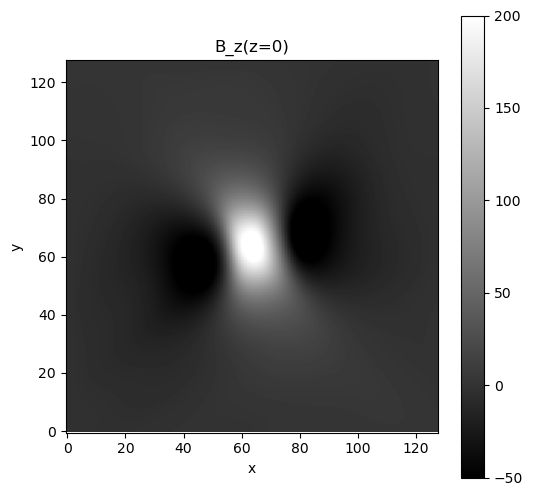

In [ ]:
B_pinn_grid.plt_Bz_imshow(z=0, vmin=-50, vmax=200)

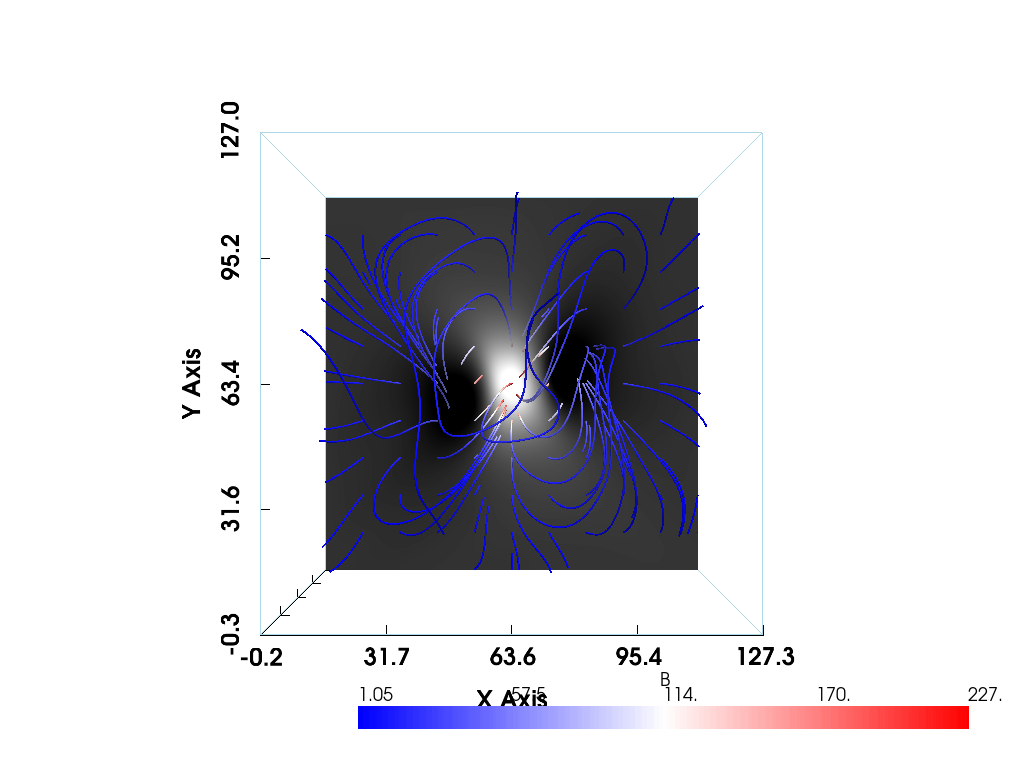

In [ ]:
B_pinn_grid.pv_streamline_Bz(camera_position='xy', i_resolution=10, j_resolution=10, vmin=-50, vmax=200)